# Collecting data on decentralized exchanges using BitQuery GraphQL API

**First we define how to run a query using API key from BitQuery**

In [73]:
import requests
import yaml
import json
import pandas as pd
import os

RESULTS_DIR = os.path.join(os.getcwd(), 'results')
QUERIES_DIR = os.path.join(os.getcwd(), 'queries')

##############################################################################################################################
# Toggle the below boolean to change whether the program fetches queries (false) or loads pre-fetched data (true)
LOAD_FROM_FILE = True
##############################################################################################################################

with open('api.yaml', 'r') as f:
    parsed_yaml = yaml.load(f, Loader=yaml.FullLoader)
    API_KEY = parsed_yaml['api']


def run_query(query):  # A simple function to use requests.post to make the API call.
    headers = {'X-API-KEY': API_KEY}
    request = requests.post('https://graphql.bitquery.io/', json={'query': query, 'variables': variables},
                            headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed and return code is {}.      {}'.format(request.status_code, query))


def write_json_to_file(json_obj, file):
    with open(file, 'w') as f_out:
        json.dump(json_obj, f_out)


def load_json_from_file(file):
    with open(file, 'r') as f_in:
        json_obj = json.load(f_in)
    return json_obj

**Define our first query, which fetches a summary of decentralized exchanges and the following metrics:**
- Trade count
- Currencies
- Contracts
- Volume in USD


In [74]:
variables = {
    "limit": 10,
    "offset": 0,
    "network": "ethereum",
    "from": "2021-01-01",
    "till": "2022-05-23T23:59:59",
    "dateFormat": "%Y-%m-%d"}

query1 = """
query ($network: EthereumNetwork!, $from: ISO8601DateTime, $till: ISO8601DateTime) {
  ethereum(network: $network) {
    dexTrades(options: {desc: "tradeAmount"}, date: {since: $from, till: $till}) {
      exchange {
        fullName
      }
      trades: count
      tradeAmount(in: USD)
      currencies: count(uniq: buy_currency)
      contracts: count(uniq: smart_contracts)
    }
  }
}
"""

if not LOAD_FROM_FILE:
    result1 = run_query(query1)  # Execute the query
    write_json_to_file(result1, os.path.join(QUERIES_DIR, 'query1.json'))
else:
    result1 = load_json_from_file(os.path.join(QUERIES_DIR, 'query1.json'))

print('Result - {}'.format(result1))

Result - {'data': {'ethereum': {'dexTrades': [{'exchange': {'fullName': 'Uniswap'}, 'trades': 68785599, 'tradeAmount': 931584327172.0623, 'currencies': 40143, 'contracts': 57555}, {'exchange': {'fullName': 'SushiSwap'}, 'trades': 8183620, 'tradeAmount': 171677332813.7874, 'currencies': 1864, 'contracts': 2407}, {'exchange': {'fullName': '<Uniswap v2>'}, 'trades': 1751660, 'tradeAmount': 137564925931.4078, 'currencies': 840, 'contracts': 1721}, {'exchange': {'fullName': 'Zerox Exchange'}, 'trades': 568420, 'tradeAmount': 33321933306.151443, 'currencies': 1021, 'contracts': 3}, {'exchange': {'fullName': 'Curve'}, 'trades': 99511, 'tradeAmount': 23440189492.228863, 'currencies': 17, 'contracts': 7}, {'exchange': {'fullName': 'Bancor Network'}, 'trades': 713386, 'tradeAmount': 19150581943.807106, 'currencies': 305, 'contracts': 1}, {'exchange': {'fullName': 'Balancer'}, 'trades': 1110774, 'tradeAmount': 18299474478.287422, 'currencies': 720, 'contracts': 1369}, {'exchange': {'fullName': 'D

In [75]:
# Convert the result to a dataframe
df1 = pd.json_normalize(result1['data']['ethereum']['dexTrades'])
print(df1)
df1.to_csv(path_or_buf=os.path.join(RESULTS_DIR, '1_exchange_overview.csv'))

      trades   tradeAmount  currencies  contracts         exchange.fullName
0   68785599  9.315843e+11       40143      57555                   Uniswap
1    8183620  1.716773e+11        1864       2407                 SushiSwap
2    1751660  1.375649e+11         840       1721              <Uniswap v2>
3     568420  3.332193e+10        1021          3            Zerox Exchange
4      99511  2.344019e+10          17          7                     Curve
5     713386  1.915058e+10         305          1            Bancor Network
6    1110774  1.829947e+10         720       1369                  Balancer
7     106244  1.769867e+10          12         12                      Dodo
8     259721  1.424920e+10          62          2       <Zerox Exchange v2>
9      48037  1.331595e+10          18         11                   <Curve>
10    181172  9.800701e+09         232          2                     1inch
11    100334  8.893685e+09           3          1                      dYdX
12    210887

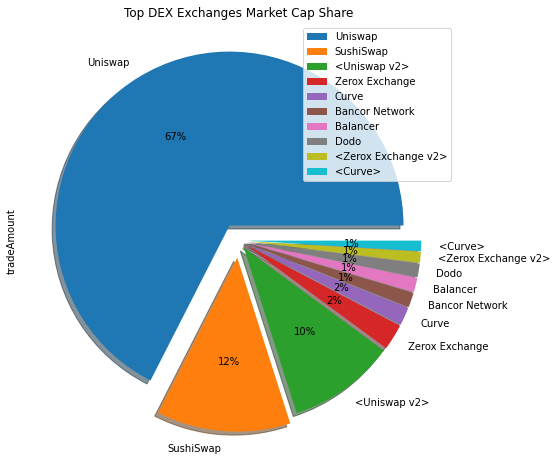

In [76]:
# Plot the data as a pie chart
pie = df1.head(10).plot(kind='pie',
                        y='tradeAmount',
                        autopct='%1.0f%%',
                        labels=df1['exchange.fullName'],
                        title='Top DEX Exchanges Market Cap Share',
                        explode=(0.10, 0.10, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05),
                        shadow=True,
                        figsize=(8, 8))

pie.legend(loc='upper right')
fig = pie.get_figure()
fig.savefig(os.path.join(RESULTS_DIR, '2_exchange_pie'))

**Next we take a look at the top traded token pairs**

In [77]:
variables = {
    "limit": 50,
    "offset": 0,
    "network": "ethereum",
    "from": "2021-01-01",
    "till": "2022-05-23T23:59:59",
    "dateFormat": "%Y-%m-%d"}

query2 = """
query ($network: EthereumNetwork!, $limit: Int!, $offset: Int!, $from: ISO8601DateTime, $till: ISO8601DateTime) {
  ethereum(network: $network) {
    dexTrades(
      options: {desc: "tradeAmount", limit: $limit, offset: $offset}
      date: {since: $from, till: $till}
    ) {
      buyCurrency {
        symbol
      }
      sellCurrency {
        symbol
      }
      count
      tradeAmount(in: USD)
      started: minimum(of: date)
    }
  }
}
"""

if not LOAD_FROM_FILE:
    result2 = run_query(query2)  # Execute the query
    write_json_to_file(result2, os.path.join(QUERIES_DIR, 'query2.json'))
else:
    result2 = load_json_from_file(os.path.join(QUERIES_DIR, 'query2.json'))

print('Result - {}'.format(result2))

Result - {'data': {'ethereum': {'dexTrades': [{'buyCurrency': {'symbol': 'WETH'}, 'sellCurrency': {'symbol': 'USDC'}, 'count': 3074420, 'tradeAmount': 172002293158.76556, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'USDC'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 2713255, 'tradeAmount': 170634721406.49026, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'SF'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 12, 'tradeAmount': 123568881602.2648, 'started': '2022-04-12'}, {'buyCurrency': {'symbol': 'WETH'}, 'sellCurrency': {'symbol': 'USDT'}, 'count': 2494699, 'tradeAmount': 66822774503.62699, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'USDT'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 2574017, 'tradeAmount': 65536039294.19888, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'DAI'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 876994, 'tradeAmount': 35397946266.80798, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'WETH'}, 'sellCurrency': {'symbol'

In [78]:
# Convert the result to a dataframe
df2 = pd.json_normalize(result2['data']['ethereum']['dexTrades'])
df2 = df2.sort_values(by='count', ascending=False)
df2['Trading Pair'] = df2['buyCurrency.symbol'] + '/' + df2['sellCurrency.symbol']
df2 = df2.head(20).drop(columns=['buyCurrency.symbol', 'sellCurrency.symbol', 'started'], axis=1)
print(df2)
df2.to_csv(path_or_buf=os.path.join(RESULTS_DIR, '3_token_pairs.csv'))

      count   tradeAmount Trading Pair
0   3074420  1.720023e+11    WETH/USDC
1   2713255  1.706347e+11    USDC/WETH
4   2574017  6.553604e+10    USDT/WETH
3   2494699  6.682277e+10    WETH/USDT
14  1331083  8.217408e+09    WETH/SHIB
6    960203  3.516560e+10     WETH/DAI
5    876994  3.539795e+10     DAI/WETH
13   634865  8.305974e+09    SHIB/WETH
8    411293  2.923150e+10    WETH/WBTC
7    378304  2.992484e+10    WBTC/WETH
9    296313  2.399724e+10    USDT/USDC
10   274015  2.398547e+10    USDC/USDT
34   239640  3.669944e+09   WETH/LOOKS
26   225694  5.272832e+09     UNI/WETH
15   224365  7.741297e+09   SUSHI/WETH
33   217602  3.686104e+09   LOOKS/WETH
42   213858  2.832326e+09     USDC/HEX
22   211934  5.510132e+09    LINK/WETH
16   206567  7.484473e+09   WETH/SUSHI
25   202900  5.323438e+09    WETH/LINK


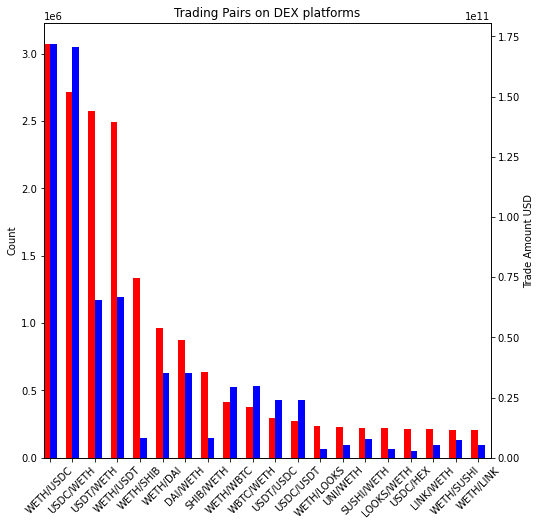

In [79]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.3
df2['count'].plot(kind='bar', color='red', ax=ax, width=width, position=1, figsize=(8, 8),
                  title='Trading Pairs on DEX platforms', rot=45)
df2['tradeAmount'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Count')
ax.set_xticklabels(df2['Trading Pair'])
ax2.set_ylabel('Trade Amount USD')
plt.show()

fig.savefig(os.path.join(RESULTS_DIR, '4_trading_pairs'))

**Next we look at the amount of trader addresses**

In [80]:
variables = {
    "limit": 10,
    "offset": 0,
    "network": "ethereum",
    "from": "2021-01-01",
    "till": "2022-05-24T23:59:59",
    "dateFormat": "%Y-%m-%d"
}

query3 = """
query ($network: EthereumNetwork!, $dateFormat: String!, $from: ISO8601DateTime, $till: ISO8601DateTime) {
  ethereum(network: $network) {
    dexTrades(options: {asc: "date.date"}, date: {since: $from, till: $till}) {
      date: date {
        date(format: $dateFormat)
      }
      trades: countBigInt
      traders: countBigInt(uniq: takers)
      contracts: countBigInt(uniq: smart_contracts)
      currencies: countBigInt(uniq: buy_currency)
    }
  }
}
"""

if not LOAD_FROM_FILE:
    result3 = run_query(query3)  # Execute the query
    write_json_to_file(result3, os.path.join(QUERIES_DIR, 'query3.json'))
else:
    result3 = load_json_from_file(os.path.join(QUERIES_DIR, 'query3.json'))

print('Result - {}'.format(result3))

Result - {'data': {'ethereum': {'dexTrades': [{'date': {'date': '2021-01-01'}, 'trades': '172478', 'traders': '30993', 'contracts': '3439', 'currencies': '1893'}, {'date': {'date': '2021-01-02'}, 'trades': '167977', 'traders': '30606', 'contracts': '3269', 'currencies': '1754'}, {'date': {'date': '2021-01-03'}, 'trades': '160319', 'traders': '29068', 'contracts': '3273', 'currencies': '1797'}, {'date': {'date': '2021-01-04'}, 'trades': '136184', 'traders': '24812', 'contracts': '2932', 'currencies': '1655'}, {'date': {'date': '2021-01-05'}, 'trades': '151698', 'traders': '28753', 'contracts': '3144', 'currencies': '1757'}, {'date': {'date': '2021-01-06'}, 'trades': '145729', 'traders': '28264', 'contracts': '3224', 'currencies': '1807'}, {'date': {'date': '2021-01-07'}, 'trades': '133913', 'traders': '26237', 'contracts': '3067', 'currencies': '1769'}, {'date': {'date': '2021-01-08'}, 'trades': '139879', 'traders': '27397', 'contracts': '3003', 'currencies': '1704'}, {'date': {'date': 

In [81]:
# Convert the result to a dataframe
df3 = pd.json_normalize(result3['data']['ethereum']['dexTrades'])
print(df3)
df3.to_csv(path_or_buf=os.path.join(RESULTS_DIR, '5_unique_traders.csv'))

     trades traders contracts currencies   date.date
0    172478   30993      3439       1893  2021-01-01
1    167977   30606      3269       1754  2021-01-02
2    160319   29068      3273       1797  2021-01-03
3    136184   24812      2932       1655  2021-01-04
4    151698   28753      3144       1757  2021-01-05
..      ...     ...       ...        ...         ...
504  103582   18431      4064       2322  2022-05-20
505   88888   16370      4158       2435  2022-05-21
506   91264   17393      4178       2423  2022-05-22
507  117302   20475      4380       2480  2022-05-23
508   60924   11729      3499       1972  2022-05-24

[509 rows x 5 columns]


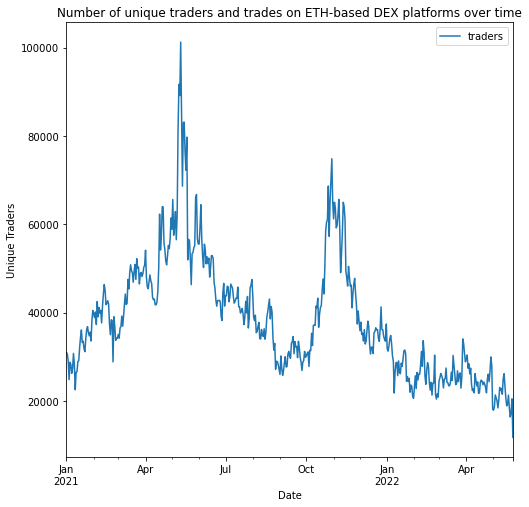

In [90]:
# Cast types for the dataframe
df3 = df3.astype({'trades': 'int32', 'traders': 'int32', 'contracts': 'int32', 'currencies': 'int32'})
df3['date.date'] = pd.to_datetime(df3['date.date'], format='%Y-%m-%d')

# Plot the data
line = df3.plot(kind='line',
               x='date.date',
               y='traders',
               figsize=(8, 8),
               title='Number of unique traders and trades on ETH-based DEX platforms over time',
               ylabel='Unique Traders',
               xlabel='Date')

fig = line.get_figure()
fig.savefig(os.path.join(RESULTS_DIR, '6_unique_traders'))